**Chapter 2 – End-to-end Machine Learning project**

*Welcome to Machine Learning Housing Corp.! Your task is to predict median house values in Californian districts, given a number of features from these districts.*

*This notebook contains all the sample code and solutions to the exercices in chapter 2.*

# Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import numpy.random as rnd
import os

# to make this notebook's output stable across runs
rnd.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# Get the data

In [2]:
DATASETS_URL = "https://github.com/ageron/handson-ml/raw/master/datasets"

In [3]:
import os
import tarfile
from six.moves import urllib

HOUSING_PATH = "datasets/housing"
HOUSING_URL = DATASETS_URL + "/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.exists(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [4]:
fetch_housing_data()

In [5]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [6]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [7]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [8]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [9]:
print(housing.describe())

          longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        421.385070   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
25%        296.00000

Saving figure attribute_histogram_plots


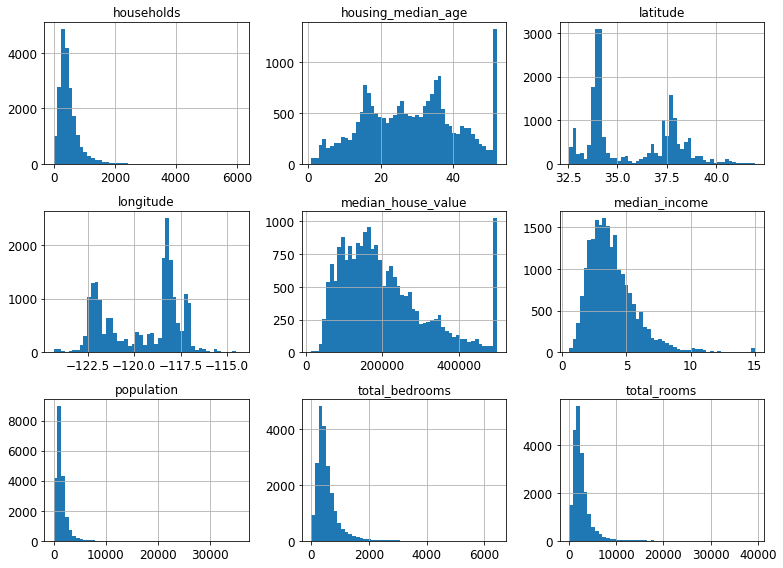

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(11,8))
save_fig("attribute_histogram_plots")
plt.show()

In [11]:
import numpy as np
import numpy.random as rnd
rnd.seed(42) # to make this notebook's output identical at every run

def split_train_test(data, test_ratio):
    shuffled_indices = rnd.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [12]:
train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set), len(test_set))

16512 4128


In [13]:
import hashlib

def test_set_check(identifier, test_ratio, hash):
    return bytearray(hash(np.int64(identifier)).digest())[-1] < 256 * test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [14]:
housing_with_id = housing.reset_index()   # adds an `index` column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")
test_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
4,4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
11,11,-122.26,37.85,52.0,3503.0,752.0,1504.0,734.0,3.2705,241800.0,NEAR BAY
20,20,-122.27,37.85,40.0,751.0,184.0,409.0,166.0,1.3578,147500.0,NEAR BAY
23,23,-122.27,37.84,52.0,1688.0,337.0,853.0,325.0,2.1806,99700.0,NEAR BAY


In [15]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


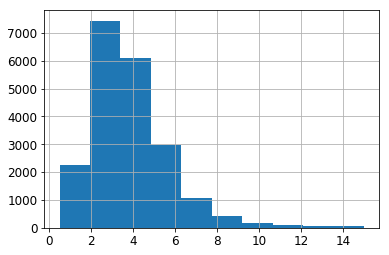

In [16]:
housing["median_income"].hist()

In [17]:
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)
housing["income_cat"].value_counts()

3.0    7236
2.0    6581
4.0    3639
5.0    2362
1.0     822
Name: income_cat, dtype: int64

In [18]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [19]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [20]:
compare_props

,Overall,Random,Stratified,Rand. %error,Strat. %error
1.0,0.039826,0.040213,0.039729,0.973236,-0.243309
2.0,0.318847,0.324370,0.318798,1.732260,-0.015195
3.0,0.350581,0.358527,0.350533,2.266446,-0.013820
4.0,0.176308,0.167393,0.176357,-5.056334,0.027480
5.0,0.114438,0.109496,0.114583,-4.318374,0.127011


In [21]:
for set in (strat_train_set, strat_test_set):
    set.drop("income_cat", axis=1, inplace=True)

# Discover and visualize the data to gain insights

In [22]:
housing = strat_train_set.copy()

Saving figure bad_visualization_plot


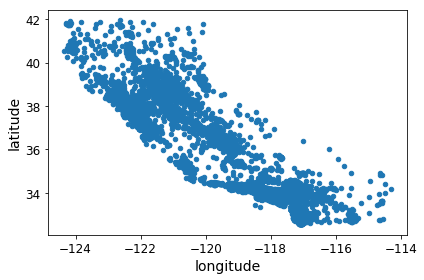

In [23]:
housing.plot(kind="scatter", x="longitude", y="latitude")
save_fig("bad_visualization_plot")

Saving figure better_visualization_plot


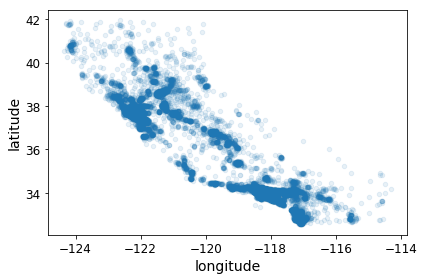

In [24]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
save_fig("better_visualization_plot")

Saving figure housing_prices_scatterplot


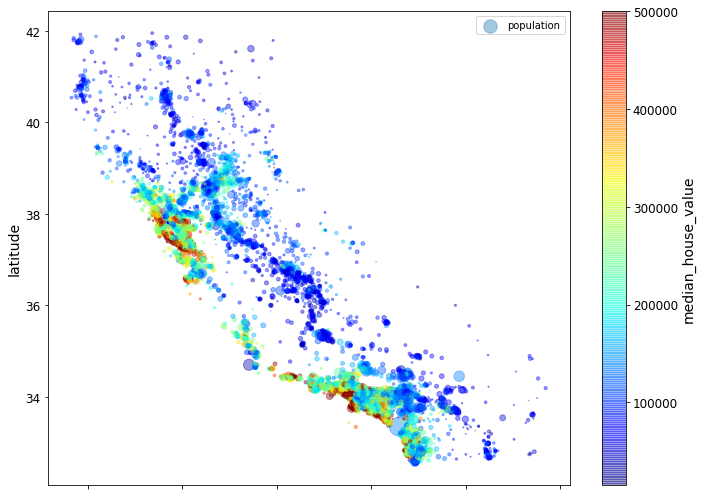

In [25]:
housing.plot(kind="scatter", x="longitude", y="latitude",
    s=housing['population']/100, label="population",
    c="median_house_value", cmap=plt.get_cmap("jet"),
    colorbar=True, alpha=0.4, figsize=(10,7),
)
plt.legend()
save_fig("housing_prices_scatterplot")
plt.show()

Saving figure california_housing_prices_plot


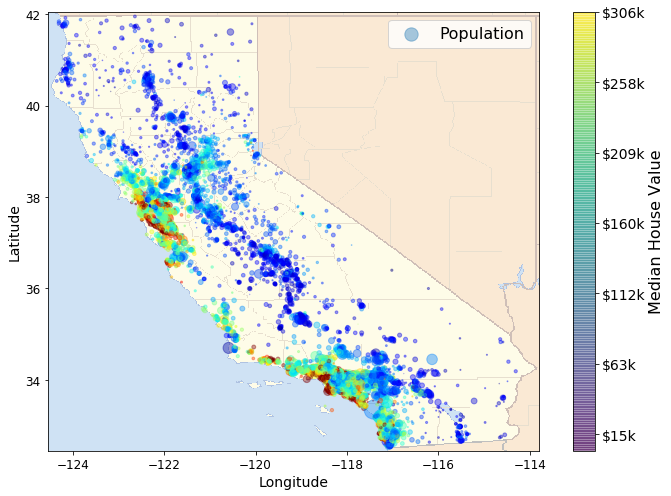

In [26]:
import matplotlib.image as mpimg
california_img=mpimg.imread(PROJECT_ROOT_DIR + '/images/end_to_end_project/california.png')
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                       s=housing['population']/100, label="Population",
                       c="median_house_value", cmap=plt.get_cmap("jet"),
                       colorbar=False, alpha=0.4,
                      )
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5)
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar()
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
save_fig("california_housing_prices_plot")
plt.show()

In [27]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

Saving figure income_vs_house_value_scatterplot


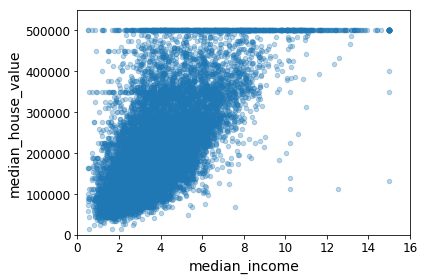

In [28]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.3)
plt.axis([0, 16, 0, 550000])
save_fig("income_vs_house_value_scatterplot")
plt.show()

Saving figure scatter_matrix_plot


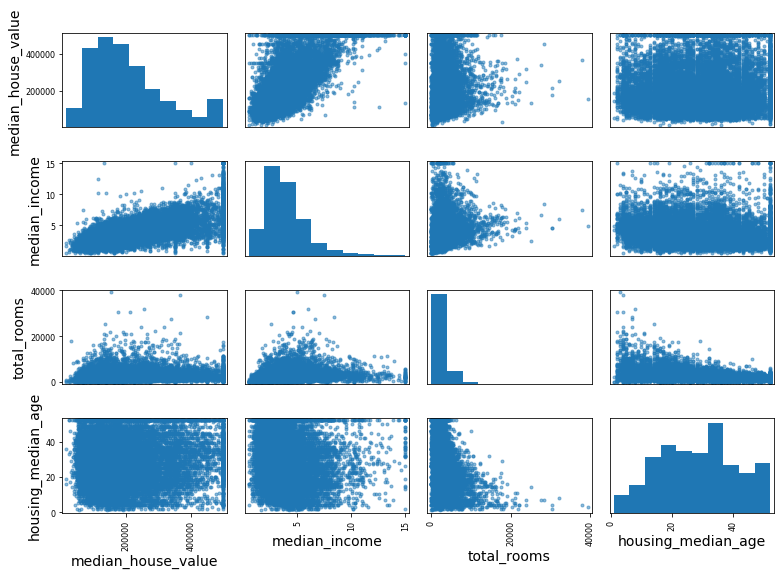

In [29]:
from pandas.tools.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(11, 8))
save_fig("scatter_matrix_plot")
plt.show()

In [30]:
housing["rooms_per_household"] = housing["total_rooms"] / housing["population"]
housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["population_per_household"] = housing["population"] / housing["households"]

In [31]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.199429
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

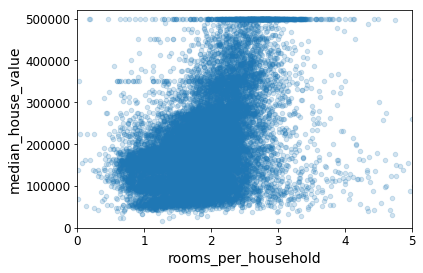

In [32]:
housing.plot(kind="scatter", x="rooms_per_household", y="median_house_value",
             alpha=0.2)
plt.axis([0, 5, 0, 520000])
plt.show()

In [33]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household
count,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000
mean,-119.575834,35.639577,28.653101,2622.728319,534.973890,1419.790819,497.060380,3.875589,206990.920724,1.982840,0.212878,3.096437
std,2.001860,2.138058,12.574726,2138.458419,412.699041,1115.686241,375.720845,1.904950,115703.014830,1.214607,0.057379,11.584826
min,-124.350000,32.540000,1.000000,6.000000,2.000000,3.000000,2.000000,0.499900,14999.000000,0.002547,0.100000,0.692308
25%,-121.800000,33.940000,18.000000,1443.000000,295.000000,784.000000,279.000000,2.566775,119800.000000,1.521534,0.175304,2.431287
50%,-118.510000,34.260000,29.000000,2119.500000,433.000000,1164.000000,408.000000,3.540900,179500.000000,1.937963,0.203031,2.817653
75%,-118.010000,37.720000,37.000000,3141.000000,644.000000,1719.250000,602.000000,4.744475,263900.000000,2.297169,0.239831,3.281420
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100,500001.000000,55.222222,1.000000,1243.333333


# Prepare the data for Machine Learning algorithms

In [34]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [35]:
housing_copy = housing.copy().iloc[21:24]
housing_copy

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
18086,-122.05,37.31,25.0,4111.0,538.0,1585.0,568.0,9.2298,<1H OCEAN
16718,-120.66,35.49,17.0,4422.0,945.0,2307.0,885.0,2.8285,<1H OCEAN
13600,-117.25,34.16,37.0,1709.0,278.0,744.0,274.0,3.7188,INLAND


In [36]:
housing_copy.dropna(subset=["total_bedrooms"])    # option 1

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
18086,-122.05,37.31,25.0,4111.0,538.0,1585.0,568.0,9.2298,<1H OCEAN
16718,-120.66,35.49,17.0,4422.0,945.0,2307.0,885.0,2.8285,<1H OCEAN
13600,-117.25,34.16,37.0,1709.0,278.0,744.0,274.0,3.7188,INLAND


In [37]:
housing_copy = housing.copy().iloc[21:24]
housing_copy.drop("total_bedrooms", axis=1)       # option 2

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
18086,-122.05,37.31,25.0,4111.0,1585.0,568.0,9.2298,<1H OCEAN
16718,-120.66,35.49,17.0,4422.0,2307.0,885.0,2.8285,<1H OCEAN
13600,-117.25,34.16,37.0,1709.0,744.0,274.0,3.7188,INLAND


In [38]:
housing_copy = housing.copy().iloc[21:24]
median = housing_copy["total_bedrooms"].median()
housing_copy["total_bedrooms"].fillna(median, inplace=True) # option 3
housing_copy

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
18086,-122.05,37.31,25.0,4111.0,538.0,1585.0,568.0,9.2298,<1H OCEAN
16718,-120.66,35.49,17.0,4422.0,945.0,2307.0,885.0,2.8285,<1H OCEAN
13600,-117.25,34.16,37.0,1709.0,278.0,744.0,274.0,3.7188,INLAND


In [39]:
from sklearn.preprocessing import Imputer

imputer = Imputer(strategy='median')
housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns)
housing_tr.iloc[21:24]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
21,-122.05,37.31,25.0,4111.0,538.0,1585.0,568.0,9.2298
22,-120.66,35.49,17.0,4422.0,945.0,2307.0,885.0,2.8285
23,-117.25,34.16,37.0,1709.0,278.0,744.0,274.0,3.7188


In [40]:
imputer.statistics_

array([ -118.51  ,    34.26  ,    29.    ,  2119.5   ,   433.    ,
        1164.    ,   408.    ,     3.5409])

In [41]:
housing_num.median().values

array([ -118.51  ,    34.26  ,    29.    ,  2119.5   ,   433.    ,
        1164.    ,   408.    ,     3.5409])

In [42]:
imputer.strategy

u'median'

In [43]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns)
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
1,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
2,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
4,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347


In [44]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
housing_cat = housing["ocean_proximity"]
housing_cat_encoded = encoder.fit_transform(housing_cat)
housing_cat_encoded

array([0, 0, 4, ..., 1, 0, 3])

In [45]:
print(encoder.classes_)

['<1H OCEAN' 'INLAND' 'ISLAND' 'NEAR BAY' 'NEAR OCEAN']


In [46]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
housing_cat_1hot

<16512x5 sparse matrix of type '<type 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [47]:
housing_cat_1hot.toarray()

array([[ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.],
       ..., 
       [ 0.,  1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.]])

In [48]:
from sklearn.preprocessing import LabelBinarizer

encoder = LabelBinarizer()
encoder.fit_transform(housing_cat)

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ..., 
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]])

In [49]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

housing_extra_attribs = pd.DataFrame(housing_extra_attribs, columns=list(housing.columns)+["rooms_per_household", "population_per_household"])
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
0,-121.89,37.29,38,1568,351,710,339,2.7042,<1H OCEAN,4.62537,2.0944
1,-121.93,37.05,14,679,108,306,113,6.4214,<1H OCEAN,6.00885,2.70796
2,-117.2,32.77,31,1952,471,936,462,2.8621,NEAR OCEAN,4.22511,2.02597
3,-119.61,36.31,25,1847,371,1460,353,1.8839,INLAND,5.23229,4.13598
4,-118.59,34.23,17,6592,1525,4459,1463,3.0347,<1H OCEAN,4.50581,3.04785


In [50]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

num_pipeline.fit_transform(housing_num)

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ..., 
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

In [51]:
from sklearn.pipeline import FeatureUnion

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('label_binarizer', LabelBinarizer()),
    ])

preparation_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])


In [52]:
housing_prepared = preparation_pipeline.fit_transform(housing)
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ..., 
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [53]:
housing_prepared.shape

(16512, 16)

# Prepare the data for Machine Learning algorithms

In [54]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

/usr/local/lib/python2.7/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [55]:
# let's try the full pipeline on a few training instances
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = preparation_pipeline.transform(some_data)

print("Predictions:\t", lin_reg.predict(some_data_prepared))
print("Labels:\t\t", list(some_labels))

Predictions:	 [ 210644.60459286  317768.80697211  210956.43331178   59218.98886849
  189747.55849878]
Labels:		 [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [56]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.198198489219

In [57]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

49439.895990018958

In [58]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

# Fine-tune your model

In [59]:
from sklearn.model_selection import cross_val_score

tree_scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                              scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-tree_scores)

In [60]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [ 69316.02634772  65498.84994772  71404.25935862  69098.46240168
  70580.30735263  75540.88413124  69717.93143674  70428.42648461
  75888.17618283  68976.12268448]
Mean: 70644.9446328
Standard deviation: 2938.93789263


In [61]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [ 66782.73843989  66960.118071    70361.18285107  74742.02956966
  68022.09224176  71193.07033936  64969.63056405  68276.69992785
  71543.69797334  67665.10082067]
Mean: 69051.6360799
Standard deviation: 2732.39242562


In [62]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

22252.738943108321

In [63]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [ 52869.23106834  49189.93801195  51726.73647871  54995.98190463
  50979.93079904  55978.43765914  52283.7609046   51001.92227546
  54447.35786983  53389.94422283]
Mean: 52686.3241195
Standard deviation: 1971.26547795


In [64]:
scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
pd.Series(np.sqrt(-scores)).describe()

count       10.000000
mean     69051.511103
std       2880.090554
min      64969.630564
25%      67136.363758
50%      68149.396085
75%      70984.165161
max      74742.024207
dtype: float64

In [65]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(housing_prepared, housing_labels)
housing_predictions = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

111094.6308539982

In [66]:
from sklearn.model_selection import GridSearchCV

param_grid = [
        {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
        {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
    ]

forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{u'n_estimators': [3, 10, 30], u'max_features': [2, 4, 6, 8]}, {u'n_estimators': [3, 10], u'max_features': [2, 3, 4], u'bootstrap': [False]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=u'neg_mean_squared_error', verbose=0)

In [67]:
grid_search.best_params_

{u'max_features': 6, u'n_estimators': 30}

In [68]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=6, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [69]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

64912.0351358 {u'max_features': 2, u'n_estimators': 3}
55535.2786524 {u'max_features': 2, u'n_estimators': 10}
52940.2696165 {u'max_features': 2, u'n_estimators': 30}
60384.0908354 {u'max_features': 4, u'n_estimators': 3}
52709.9199934 {u'max_features': 4, u'n_estimators': 10}
50503.5985321 {u'max_features': 4, u'n_estimators': 30}
59058.1153485 {u'max_features': 6, u'n_estimators': 3}
52172.0292957 {u'max_features': 6, u'n_estimators': 10}
49958.9555932 {u'max_features': 6, u'n_estimators': 30}
59122.260006 {u'max_features': 8, u'n_estimators': 3}
52441.5896087 {u'max_features': 8, u'n_estimators': 10}
50041.4899416 {u'max_features': 8, u'n_estimators': 30}
62371.1221202 {u'max_features': 2, u'n_estimators': 3, u'bootstrap': False}
54572.2557534 {u'max_features': 2, u'n_estimators': 10, u'bootstrap': False}
59634.0533132 {u'max_features': 3, u'n_estimators': 3, u'bootstrap': False}
52456.0883904 {u'max_features': 3, u'n_estimators': 10, u'bootstrap': False}
58825.665239 {u'max_feature

In [70]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_bootstrap,param_max_features,param_n_estimators,params,rank_test_score,split0_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.132040,0.009721,-4.213572e+09,-1.122089e+09,NaN,2,3,"{u'max_features': 2, u'n_estimators': 3}",18,-4.322392e+09,...,-4.091199e+09,-1.132659e+09,-4.048299e+09,-1.084169e+09,-4.278616e+09,-1.181979e+09,0.041521,0.002831,1.194097e+08,4.503304e+07
1,0.486171,0.049584,-3.084167e+09,-5.686194e+08,NaN,2,10,"{u'max_features': 2, u'n_estimators': 10}",11,-2.920668e+09,...,-3.189759e+09,-5.684440e+08,-2.977423e+09,-5.753131e+08,-3.140389e+09,-5.569981e+08,0.083849,0.017615,1.133146e+08,1.555889e+07
2,1.129142,0.070678,-2.802672e+09,-4.390709e+08,NaN,2,30,"{u'max_features': 2, u'n_estimators': 30}",9,-2.635798e+09,...,-2.899767e+09,-4.299952e+08,-2.628577e+09,-4.459977e+08,-2.910563e+09,-4.319555e+08,0.363709,0.015123,1.398004e+08,6.703308e+06
3,0.121882,0.005771,-3.646238e+09,-9.779480e+08,NaN,4,3,"{u'max_features': 4, u'n_estimators': 3}",16,-3.583831e+09,...,-3.950913e+09,-9.887841e+08,-3.308822e+09,-1.011182e+09,-3.662211e+09,-9.190933e+08,0.009266,0.000959,2.083609e+08,3.282495e+07
4,0.384682,0.016761,-2.778336e+09,-5.111719e+08,NaN,4,10,"{u'max_features': 4, u'n_estimators': 10}",8,-2.703532e+09,...,-2.884782e+09,-4.948073e+08,-2.650746e+09,-5.355259e+08,-2.882622e+09,-5.245530e+08,0.051824,0.001635,9.396457e+07,2.504651e+07
5,1.683741,0.084448,-2.550613e+09,-3.959620e+08,NaN,4,30,"{u'max_features': 4, u'n_estimators': 30}",3,-2.302148e+09,...,-2.682066e+09,-3.923106e+08,-2.492072e+09,-4.120956e+08,-2.653622e+09,-3.940042e+08,0.339261,0.032796,1.402365e+08,8.599915e+06
6,0.330596,0.012042,-3.487861e+09,-9.302686e+08,NaN,6,3,"{u'max_features': 6, u'n_estimators': 3}",13,-3.323532e+09,...,-3.477330e+09,-8.673024e+08,-3.255834e+09,-9.719544e+08,-3.719818e+09,-9.505729e+08,0.060533,0.006623,1.818530e+08,3.502555e+07
7,1.071488,0.037747,-2.721921e+09,-5.009736e+08,NaN,6,10,"{u'max_features': 6, u'n_estimators': 10}",5,-2.605933e+09,...,-2.871511e+09,-4.944972e+08,-2.601547e+09,-5.127494e+08,-2.799685e+09,-4.853162e+08,0.348721,0.016734,1.062510e+08,1.527767e+07
8,1.689853,0.060501,-2.495897e+09,-3.848766e+08,NaN,6,30,"{u'max_features': 6, u'n_estimators': 30}",1,-2.410445e+09,...,-2.600516e+09,-3.791315e+08,-2.304437e+09,-3.834466e+08,-2.627380e+09,-3.763532e+08,0.147796,0.013107,1.215337e+08,7.051109e+06
9,0.201927,0.006598,-3.495442e+09,-8.965714e+08,NaN,8,3,"{u'max_features': 8, u'n_estimators': 3}",14,-3.274179e+09,...,-3.517974e+09,-9.317195e+08,-3.512932e+09,-9.331547e+08,-3.562802e+09,-8.541539e+08,0.004247,0.001089,1.160130e+08,3.128209e+07


In [71]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor()
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error')
rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=10, n_jobs=1,
          param_distributions={u'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1119ffd90>, u'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x111a428d0>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring=u'neg_mean_squared_error',
          verbose=0)

In [72]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

50239.6442738 {u'max_features': 3, u'n_estimators': 121}
50307.8432326 {u'max_features': 3, u'n_estimators': 187}
49185.0150532 {u'max_features': 6, u'n_estimators': 88}
49133.3305418 {u'max_features': 5, u'n_estimators': 137}
49021.6318804 {u'max_features': 7, u'n_estimators': 197}
49636.8878839 {u'max_features': 6, u'n_estimators': 39}
52273.457854 {u'max_features': 2, u'n_estimators': 50}
54413.8506712 {u'max_features': 1, u'n_estimators': 184}
51953.3364641 {u'max_features': 2, u'n_estimators': 71}
49174.1414792 {u'max_features': 6, u'n_estimators': 140}


In [73]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([  7.38167445e-02,   6.93425001e-02,   4.41741354e-02,
         1.80040251e-02,   1.65486595e-02,   1.80013616e-02,
         1.59794977e-02,   3.32716759e-01,   5.57319056e-02,
         1.05464076e-01,   8.70481930e-02,   9.90812199e-03,
         1.43083072e-01,   1.03976446e-04,   3.87833961e-03,
         6.19863203e-03])

In [74]:
extra_attribs = ["rooms_per_household", "population_per_household", "bedrooms_per_room"]
cat_one_hot_attribs = list(encoder.classes_)
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.33271675888101543, 'median_income'),
 (0.143083072155538, 'INLAND'),
 (0.10546407641519769, u'population_per_household'),
 (0.087048193008911728, u'bedrooms_per_room'),
 (0.073816744482605889, 'longitude'),
 (0.069342500136275007, 'latitude'),
 (0.055731905592885149, u'rooms_per_household'),
 (0.0441741353556422, 'housing_median_age'),
 (0.018004025077788675, 'total_rooms'),
 (0.018001361574586823, 'population'),
 (0.016548659526332148, 'total_bedrooms'),
 (0.015979497714769569, 'households'),
 (0.0099081219902823602, '<1H OCEAN'),
 (0.0061986320346514171, 'NEAR OCEAN'),
 (0.003878339607642522, 'NEAR BAY'),
 (0.00010397644587548846, 'ISLAND')]

In [75]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_transformed = preparation_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_transformed)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

47728.481110152476

# Extra material

## Label Binarizer hack
`LabelBinarizer`'s `fit_transform()` method only accepts one parameter `y` (because it was meant for labels, not predictors), so it does not work in a pipeline where the final estimator is a supervised estimator because in this case its `fit()` method takes two parameters `X` and `y`.

This hack creates a supervision-friendly `LabelBinarizer`.

In [76]:
class SupervisionFriendlyLabelBinarizer(LabelBinarizer):
    def fit_transform(self, X, y=None):
        return super(SupervisionFriendlyLabelBinarizer, self).fit_transform(X)

# Replace the Labelbinarizer with a SupervisionFriendlyLabelBinarizer
cat_pipeline.steps[1] = ("label_binarizer", SupervisionFriendlyLabelBinarizer())

# Now you can create a full pipeline with a supervised predictor at the end.
full_pipeline = Pipeline([
        ("preparation", preparation_pipeline),
        ("linear", LinearRegression())
    ])

full_pipeline.fit(housing, housing_labels)
full_pipeline.predict(some_data)

array([ 210644.60459286,  317768.80697211,  210956.43331178,
         59218.98886849,  189747.55849878])

## Model persistence using joblib

In [77]:
from sklearn.externals import joblib

In [78]:
joblib.dump(final_model, "my_random_forest_regressor.pkl")

[u'my_random_forest_regressor.pkl']

In [79]:
final_model_loaded = joblib.load("my_random_forest_regressor.pkl")
final_model_loaded

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=6, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

## Example SciPy distributions for `RandomizedSearchCV`

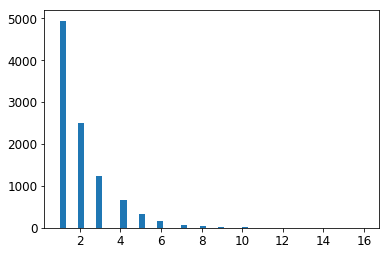

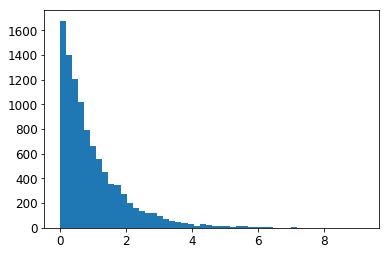

In [80]:
from scipy.stats import geom, expon
geom_distrib=geom(0.5).rvs(10000)
expon_distrib=expon(scale=1).rvs(10000)
plt.hist(geom_distrib, bins=50)
plt.show()
plt.hist(expon_distrib, bins=50)
plt.show()

# Exercise solutions

**Coming soon**